# Case study: Reinforcement Learning (via Actor-Critic)
### We use RatInABox to train an Agent to find a navigate towards rewards using the Actor-Critic algorithm. 

## Actor-Critic Introduction

In our [other tutorial](./reinforcement_learning_example.pynb) we used a value-based RL algorithm to train an Agent to find a reward hidden behind a wall. Here we'll use a policy gradient algorithm called Actor-Critic which directly learns an optimal policy in the form of a neural network called the "Actor". The Actor is trained by another neural network known as the "Critic" which estimates the value. 

__Actor__: Represents a policy which maps the state of the `Agent` to a distribution over actions that can be sampled from.
$$ \pi(a|s;\theta) = P(A(t)=a|S(t)=s)\hspace{20mm} \textrm{Policy (learned by the Actor)}$$

* The state space will be encoded by the firing rate of a bunch of cells (`PlaceCells`, `ObjectVectorCells`, we can choose whatever we like), denoted by $S(t) = \vec{f}_a(t) \in \mathbb{R}^{N_{\textrm{cells}}}$.
* The action space is a velocity vector the `Agent` will move along; $A(t) = \vec{v}(t) \in \mathbb{R}^2$
* The policy is approximated by a deep feedforward neural network with parameters $\theta$. There are many ways we could do this, here it will put out a two-vector $\vec{\mu}_{v} \in \mathbb{R}^2$ representing the mean of a distribution from which $ \vec{v}(t)$ will be drawn (described later).

__Critic__: Represents an estimate of the value of the current state. This is the expected discounted reward from the current state, with a discounting time horizon, $\tau$.
$$\mathsf{\hat{V}}(S(t);w) = \mathsf{V}^{\pi}(S(t)) = \mathbb{E} \bigg[  \int_{t}^{\infty} e^{-\frac{t^{\prime}-t}{\tau}} \mathsf{R}(t^{\prime}) dt^{\prime}\bigg] \hspace{20mm} \textrm{Value function (learned by the Critic)}$$

* The state space (again, `PlaceCells`, `ObjectVectorCells`, whatever we like) _doesn't need to be the same cells as those received by the Actor_.

Note that by definition the value function satisfies the Bellman equation $\mathsf{R}(t) +  d\mathsf{V^{\pi}}(t)/dt - \mathsf{V^{\pi}(t)}/\tau = 0$  there we can define a quantity called the TD-error which represents how "wrong" our estimate of the value function is. This is given by

$$\delta(t) = \mathsf{R}(t) +  \frac{d\mathsf{\hat{V}}(t)}{dt} - \frac{\mathsf{\hat{V}(t)}}{\tau} \hspace{20mm}\textrm{TD error: calculated by the critic, used to train the actor and critic networks}$$

### Why is there a Critic _as well as_ an Actor

It comes down to how we train the Actor. Whereas in value-based methods we use value estimates directly by choosing the action that takes us to the next state with the greatest value. Here it is only used as a means to train the actor. The learning rule for the Actor is: 

$$\frac{d\theta}{dt} = \eta \delta(t) \nabla_{\theta} \log \pi(A(t)|S(t);\theta)$$

Roughly speaking, this says "if we got _more_ reward than we were expecting ($\delta(t)>0$) tweak the parameters $\theta$ to increase the (log) probability of taking the action we just took again next time". This is the policy gradient theorem. (For a comprehensive understanding of these learning rules we recommend reading chapter 13 in [Sutton and Barto's free book on RL](http://incompleteideas.net/book/the-book-2nd.html)). Notice this update rule contains the term $\delta(t)$ which requires knowledge of the value of the state -- or at least an estimate of it -- this is why we also require the critic. 

The critic learns according to an almost identical learning rule: 

$$\frac{dw}{dt} = \eta \delta(t) \nabla_w \hat{V}(S(t);w)$$

Roughly speaking, this says "if we got _more_ reward than we were expecting ($\delta(t)>0$) tweak the parameters $w$ to increase the estimated value of this state.". This is the temporal difference learning rule. Of course, strictly, the critic learning rule requires that the value estimate has converged to the true value function. In practice, it's okay to learn them simultaneously, and hope they both converge alongside one another. 

<img src="../.images/demos/actor_critic.png" width="800" align="center">

### Eligibility traces
One final note to add is that we can use eligibility traces to speed up learning. This technique updates the weights of the network based on a decaying recent history of states and actions. To do this we maintain decaying memory traces of the network gradients and update weights along those directions e.g.  

$$e_a(t) = \frac{1}{\tau_{\mathsf{e}}} \int_{-\infty}^{t}  e^{-\frac{t-t^{\prime}}{\tau_{\mathsf{e}}}} \nabla_{\theta} \log \pi(A(t^{\prime})|S(t^{\prime});\theta) dt^{\prime}$$
$$e_c(t) = \frac{1}{\tau_{\mathsf{e}}} \int_{-\infty}^{t}  e^{-\frac{t-t^{\prime}}{\tau_{\mathsf{e}}}} \nabla_w \hat{V}(S(t^{\prime});w) dt^{\prime}$$

such that the learning rules become: 

$$\frac{d\theta}{dt} = \eta \delta(t) e_a(t) \hspace{10mm}\frac{dw}{dt} = \eta \delta(t) e_c(t) $$

### Implementation

In the below code, we'll build this system. 
1. We'll build a simple 2D environment where the `Agent` is placed in a 2D box and can move around. The `Agent` will be given a reward for reaching a reward at which point it will be teleported to a new random location.
2. We'll make `Actor` and `Critic` classes whose firing rates report the value and policy for the `Agent`. Each class is responsible for maintaining its eligibility traces and implementing its learning rules. 
3. We'll have a global "loop" that will run the `Agent` in the environment and update the `Actor` and `Critic` accordingly.




In [1]:
#ratinabox stuff
import ratinabox
from ratinabox.Agent import Agent
from ratinabox.Neurons import PlaceCells
from ratinabox.contribs.NeuralNetworkNeurons import NeuralNetworkNeurons #for the Actor and Critic
ratinabox.autosave_plots = True; ratinabox.figure_directory = "./figures/"; ratinabox.stylize_plots()

#misc
import torch 
import numpy as np 
from gymnasium.spaces import Box
from tqdm import tqdm
import time

#autoreload while in dev mode
%load_ext autoreload
%autoreload 2

### Define some constants

In [2]:
#TASK CONSTANTS
DT = 0.1 # Time step
T_TIMEOUT = 15 # Time out
GOAL_POS = np.array([0.5, 0.5]) # Goal position
WALL = None
GOAL_RADIUS = 0.1
REWARD = 1 # Reward
REWARD_DURATION = 1 # Reward duration

#LEARNING CONSTANTS
TAU = 5 # Discount time horizon
TAU_E = 5 # Eligibility trace time horizon
ETA = 0.01 # Learning rate 
N_EPISODES = 5000 # Number of episodes
L2 = 0.000 # L2 regularization

You can ignore these helper plotting functions - they aren't core the RL algorithm 

In [3]:
#visualisations
import matplotlib 
import matplotlib.pyplot as plt 

def display_reward_patch(fig, ax, reward_pos=GOAL_POS, reward_radius=GOAL_RADIUS, **kwargs): #we'll also use this later 
    """Plots the reward patch on the given axis"""
    circle = matplotlib.patches.Circle(reward_pos, radius=reward_radius,
                                       facecolor='r', alpha=0.2, color=None) 
    ax.add_patch(circle)
    return fig, ax 


def plot_reward_history(env, smooth=100):
    """Takes an environment and used its episode data to diplay the time series of rewards and the same data smoothed over `smooth` episodes"""
    fig, ax = plt.subplots(figsize=(6,2))
    data = env.episodes
    episodes = data['episode'][:-1]
    durations = data['duration']
    smoothed_durations = np.convolve(durations, np.ones(smooth)/smooth, mode='full')[:len(durations)]
    ax.scatter(episodes,durations,alpha=0.4)
    ax.plot(episodes[smooth:],smoothed_durations[smooth:])
    ax.set_xlabel("Episodes")
    ax.set_ylabel("Duration")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0,max(durations)+0.1)
    return fig, ax

def ego_to_allo(v_ego, head_direction):
    """Converts an egocentric velocity vector to an allocentric one by by rotating it by the bearing of the agents current head direction"""
    bearing = ratinabox.utils.get_bearing(head_direction)
    v_allo = ratinabox.utils.rotate(v_ego, -bearing) #bearing measured clockwise from north, so we rotate anticlockwise by -bearing
    return v_allo

## Making the task environment 

We'll make an environment and task we would like our `Agent` to solve. For this, we'll exploit the RatInABox `TaskEnvironment` which wraps a RatInABox `Environment` in order to be compatible with the `gym` API. Note we don't have to do this, in this simple case it would be feasible for us to write all the task logic ourselves but we'll use `TaskEnvironment` for simplicity. Some specific details:
* The environment is a `SpatialGoalEnvironment`: the objective is to navigate towards a spatial goal. 
* Upon reaching the spatial goal a short reward is released to the `Agent`, 
* The episode terminates shortly after the `Agent` reaches the goal _or_  "times-out" if no goal is found.  
* After termination the `Agent` respawns in a random location in the `Environment`. 
* The observation space is the firing rate of 100 RatInABox `PlaceCells`. 

The elegance of the gym API means we can now use `env.step1()` which will return a tuple of (`observation`, `reward`, `terminate_episode`, `truncate_experiment`, `info`)

We'll wrap this code in a function which returns the `env` and `ag`

In [4]:
from ratinabox.contribs.TaskEnvironment import (SpatialGoalEnvironment, SpatialGoal, Reward)

def generate_navigation_task_env():
    # Make the environment and add a wall 
    env = SpatialGoalEnvironment(
        dt=DT,
        teleport_on_reset=True,
        episode_terminate_delay=REWARD_DURATION,)
    env.exploration_strength = 1 
    if WALL is not None: env.add_wall(WALL)
    #Make the reward which is given when a spatial goal is satisfied. Attached this goal to the environment
    reward = Reward(REWARD,decay="none",expire_clock=REWARD_DURATION,dt=DT,)
    goals = [SpatialGoal(env,pos=GOAL_POS,goal_radius=GOAL_RADIUS, reward=reward)]
    env.goal_cache.reset_goals = goals 
    #Recruit the agent and add it to environment
    ag = Agent(env,params={'dt':DT})
    env.add_agents(ag) #<-- this updates the agent creating an off by one error 

    return env, ag

Now lets test is out for 200 seconds of random exploration. When we do `env.step1()` if we don't pass in any action we fall back to the RatInABox random motion policy.  

Under the random policy the Agent completed the task 7 times and timed-out 11 times.

Figure saved to /Users/tomgeorge/Documents/RatInABox/demos/figures/28_08_23/trajectory_1529.png  & .svg


Text(0.5, 1.0, 'Reward rate')

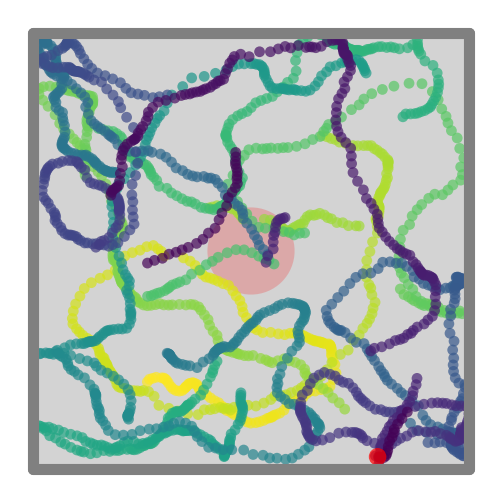

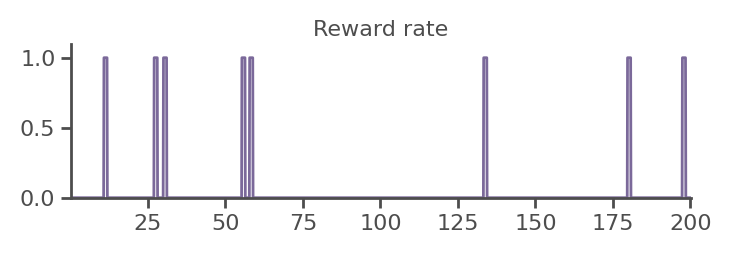

In [5]:
env, ag = generate_navigation_task_env() # make the task environment and agent

rewards = [] # For plotting
while env.t < 200: 
    observation, reward_rate, terminate_episode, _ , info =  env.step1()
    if env.t - env.episodes['start'][-1] > T_TIMEOUT:  env.reset(episode_meta_info="timeout")
    elif terminate_episode: env.reset(episode_meta_info="completed")
    rewards.append(reward_rate)

print(f"Under the random policy the Agent completed the task {(np.array(env.episodes['meta_info']) == 'completed').sum()} times and timed-out {(np.array(env.episodes['meta_info']) == 'timeout').sum()} times.\n")

#display the trajectory 
fig, ax = ag.plot_trajectory(color="changing")
display_reward_patch(fig,ax)

#show the reward timeseries
fig, ax = plt.subplots(figsize=(4,1))
ax.plot(ag.history["t"],rewards)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
ax.set_ylim(0,max(rewards)+0.1)
ax.set_title("Reward rate")

## Making the Actor and the Critic

Here we make the Actor and Critic networks. It's a decent chunk of code so let's break it down: 

`Actor`s and `Critic`s are just neural networks wrapped up and packaged to behave like RatInABox `Neurons`. In fact, they are a subclass of `NeuralNetworkNeurons`; this means that when `.update()` is called the firing rates of a set of input `Neurons` (`PlaceCells` `GridCells`...whatever, this is the "state" of the `Agent`) are queried, concatenated and passed through a PyTorch neural network which we will provide. The output -- intended to represent the value (critic) or action distribution parameters (actor) -- is saved as the firing rate, e.g. `Actor.firingrate` (numpy) or `Actor.firingrate_torch` (torch, for taking gradients). As you'll see, these classes also have internal methods which initialise/update the eligibility traces and update the weights according to the learning rules we described up above. Because actors and critics have a lot in common (they both keep eligibility traces, and they both have almost identical learning rules) we share a lot of their logic in the `BaseActorCritic` class. Since both the `Actor` and `Critic` are RatInABox `Neurons` we can query their rate maps before/after learning to instantly visualise the learned policy or we can access their `.history` to see what went on during training.

Users need to provide the following information:
1. The inputs: Any list of RatInABox `Neurons` encoding the "state". The Actor and Critic don't need to have the same inputs.
2. The neural network module: Any torch.nn.module with a `.forward()` method which maps the inputs to the outputs (value for the critic, action distribution parameters for the actor). 

In [6]:
class BaseActorCritic(NeuralNetworkNeurons):
    """Since actors and critics have similar learning rules and trace updates we share some logic here. This is a RatInABox Neurons subclass so you can query rate maps with `.plot_rate_map()` and see history in `.history`"""
    
    default_params = {
        "tau": TAU, #The time horizon of the value function 
        "tau_z": TAU_E, #The time horizon of the eligibility trace
        "input_layers": [],  # a list of input layers, each must be a ratinabox.Neurons class
        "NeuralNetworkModule": None, #Any torch nn.Sequential or nn.Module with a .forward() method
        "optimizer": lambda params: torch.optim.SGD(params, lr=ETA,  maximize=True, weight_decay=L2), #The optimizer to use (in practise I've tried Adam but it aint great). Also, remember this must maximize not minimize. 
        }

    def __init__(self, Agent, params={}):
        """Initialise the actor or critic neurons. Provide the Agent and any parameters which must include the pytorch nn.Module to use as the neural network and a list of Neurons which act as the input layers."""
        self.params = __class__.default_params.copy()
        self.params.update(params)
        super().__init__(Agent, self.params)
        self.initialise_traces()
        self.firingrate = self.get_state(save_torch=True) 
        self.firingrate_last = self.firingrate
        if self.params["optimizer"] is not None:
            self.optimizer = self.params["optimizer"](self.NeuralNetworkModule.parameters())
        return  
    
    def initialise_traces(self):
        """We maintain a trace of the gradients for all parameters in the network. This function initialises the traces to zero."""
        self.traces = []
        for (i,param) in enumerate(self.NeuralNetworkModule.parameters()):
            shape = param.detach().numpy().shape #one trace in total 
            self.traces.append(np.zeros(shape))
        return   

    def _train_step(self, L, td_error):
        """Implements a full training step: calculates the gradients, updates the traces then steps the optimizer"""
        self._calculate_gradients(L = L)
        self._update_traces(td_error = td_error)
        self.optimizer.step()
        return
    
    def _calculate_gradients(self, L):
        """Calculate the gradients of L with respect to the weights. This is generic, for the critic L = V(S) (the value of the state) and for the actor L = log_prob(A | S) (the log probability of the action just taken)
    
        Args:   
            L (torch.Tensor): What to take the gradient of (must be differentiable)"""
        self.NeuralNetworkModule.zero_grad()
        L.backward(retain_graph=True)
        return

    def _update_traces(self, td_error):
        """Update the gradient traces for each output. These eligibility traces are just the gradients smoothed with an exponential kernel of timescale tau_z. We also then loop back through and """
        for (j,param) in enumerate(self.NeuralNetworkModule.parameters()):
            #trace update : z(t+dt) = (1-dt/tau_z) * z(t) + dt/tau_z * x(t) where z is the trace and x is whats being traced
            dt = self.Agent.dt; tau_z = self.tau_z
            x = param.grad.detach().numpy() #the update
            e = self.traces[j] #the trace for this output
            self.traces[j] = (1-dt/tau_z) * e + (dt/tau_z) * x
            #then set the grad to be the trace times the td error so the optimizer can access it
            param.grad = torch.tensor(self.traces[j] * td_error * self.Agent.dt, dtype=torch.float) # dt makes this update timestep invariant


# The actor and critic only different slightly in their .update() functions so we can inherit from the same base class

class Critic(BaseActorCritic):    
    default_params = {} # see BaseActorCritic for the default params
    def update(self, reward, train=True):
        """Accepts the reward just observed, calcuates the TD error, then updates the weights based on the gradient of its firing rate and the TD error. Finally, it updates the firing rate to reflect to new position of the Agent."""
        self._update_td_error(reward) 
        if train: super()._train_step(L = self.firingrate_torch, td_error = self.td_error)#does learning on the weights
        self.firingrate_last = self.firingrate
        super().update()  # FeedForwardLayer builtin function. 
        return

    def _update_td_error(self, reward):
        """Update the temporal difference error using the current firing rate, temporal derivative of the firing rate and the reward."""
        self.dfiringrate_dt = (self.firingrate - self.firingrate_last) / self.Agent.dt
        self.td_error = (reward + self.dfiringrate_dt - self.firingrate / self.tau).item()  # this is the continuous analog of the TD error (a scalar) 
        return

class Actor(BaseActorCritic):
    default_params = {} # see BaseActorCritic for the default params
    def update(self, log_prob=None, td_error=None, train=True):
        """Accepts the (differentiable) log probability of the action just taken and the critic's latest TD error them updates the weights based on the gradient of the log probability and the TD error. Finally, it updates the firing rate to reflect to new position of the Agent."""
        if train: super()._train_step(L = log_prob, td_error = td_error)#does learning on the weights #does learning on the weights
        super().update()
        return

### The `NeuralNetworkModules` for the Actor and Critic
The above just gives the logic, updating and training rules etc. for the `Actor` and the `Critic` but specifies nothing about the details of the neural networks themselves. For this, we'll use `PyTorch`. 

RatInABox `NeuralNetworkNeurons` (like the actor and critic) require the user to pass a PyTorch `nn.Module` (basically anything with a `.forward()` method) under the parameter called `"NeuraNetworkModule`. Before we piece this all together the final thing to do is to make the neural networks corresponding to the actor and the critic. For the critic, we'll use a fairly generic multi-layer perceptron (MLP), hidden layers are ReLU and the last layer is linear. For the actor, we'll use the _same_ MLP but with a final layer which outputs converts the output to be compatible with the distribution is it representing (e.g. softmax for categorical distributions, or tanh for bounded Gaussians). The actor also contains a `.sample_action()` method...
 
* `NeuralNetworkModule.sample_action()`: For the actor the output of the neural network doesn't literally encode the action (i.e. a velocity vector [$v_x$,$v_y$]) - rather it outputs parameters of a _distribution_ from which actions are sampled (the policy). This means we must also provide a `.sample_action()` function which takes in a firing rate and returns a randomly sampled action (a velocity vector). If `log_prob=True` then this will also calculate and return the log-probability of the sampled action under the policy, this is a `torch.Tensor` which we can take gradients through.  

In [7]:
# for the Actor and Critic neural networks
import torch 
import torch.nn as nn

#=================================== a basic MLP for the CRITIC =======================================
class MultiLayerPerceptron(nn.Module):
    """A generic ReLU neural network class, default used for the core function in NeuralNetworkNeurons. 
    Specify input size, output size and hidden layer sizes (a list). Biases are used by default.

    Args:
        n_in (int, optional): The number of input neurons. Defaults to 20.
        n_out (int, optional): The number of output neurons. Defaults to 1.
        n_hidden (list, optional): A list of integers specifying the number of neurons in each hidden layer. Defaults to [20,20]."""

    def __init__(self, n_in=20, n_out=1, n_hidden=[20,20]):
        nn.Module.__init__(self)
        n = [n_in] + n_hidden + [n_out]
        layers = nn.ModuleList()
        for i in range(len(n)-1):
            layers.append(nn.Linear(n[i],n[i+1]))
            if i < len(n)-2: layers.append(nn.ReLU()) #add a ReLU after each hidden layer (but not the last)
        self.net = nn.Sequential(*layers)

    def forward(self, X):
        """Forward pass, X must be a torch tensor. Returns an (attached) torch tensor through which you can take gradients. """
        return self.net(X)
    

#=================================== a little more wrapping for the ACTOR ===========================================
class VxVyGaussianMLP(MultiLayerPerceptron):
    """In this instance, the output of the actor is a 2 dimensional vector representing the mean of v_x and the mean of v_y (each will then be sampled from a gaussian with the same variance)."""
    def __init__(self,n_in,
                 n_hidden = [50,], 
                 max_speed=0.5,):
        self.n = 2
        self.max_speed = max_speed
        super().__init__(n_in = n_in, n_hidden=n_hidden, n_out=self.n)

    def forward(self, X): # tanh activation to bound the output between -max_speed and max_speed
        return self.max_speed*torch.tanh(super().forward(X))

    def sample_action(self, firingrate : torch.tensor):
        """Samples the 2D Gaussian distribution and returns a 2D action vector corresponding to the sampled velocity and the log prob of that action."""
        std = torch.sqrt(torch.sum(firingrate.detach()**2))/2 #the standard deviation is half the magnitude of the mean
        std = 0.1
        vx_dist = torch.distributions.Normal(firingrate[:,0],scale=std)
        vy_dist = torch.distributions.Normal(firingrate[:,1],scale=std)
        vx = vx_dist.sample()
        vy = vy_dist.sample()
        action = np.array([vx.item(), vy.item()])
        log_prob = vx_dist.log_prob(torch.tensor([vx])) + vy_dist.log_prob(torch.tensor([vy]))
        return action, log_prob


#you can also try a discrete action space if you like (it works well)
class NESWCategoricalMLP(MultiLayerPerceptron):
    """In this instance, the output of the network is a 4 dimensional vector representing the probability (hence softmax) of moving in each direction, NESW."""
    def __init__(self,n_in, 
                 n_hidden = [50,],
                 speed = 0.2):
        self.n = 4
        self.speed = speed
        super().__init__(n_in = n_in, n_hidden=n_hidden, n_out=self.n)
    
    def forward(self, X): #extra softmax layer for probabilities
        return torch.softmax(super().forward(X),dim=1) 
    
    def sample_action(self, firingrate : torch.tensor):
        """Samples the categorical distribution and returns a 2D action vector corresponding to the selected action (NESW) and the log prob of that action."""
        dist = torch.distributions.Categorical(firingrate)
        firingrate = firingrate.detach()
        choice = dist.sample()
        if   choice.item() == 0: action = self.speed*np.array([0,1])
        elif choice.item() == 1: action = self.speed*np.array([1,0])
        elif choice.item() == 2: action = self.speed*np.array([0,-1])
        elif choice.item() == 3: action = self.speed*np.array([-1,0])
        log_prob = dist.log_prob(torch.tensor([choice]))
        return action, log_prob

## Now let's set up the training loop...

Running an episode is then straightforward.
At the start of each episode reset the traces for the `Actor` and the `Critic` (`.initialise_traces()`). 
Then loop: 
1. Sample an `action` and its `log_prob`: (`Actor.sample_action()`)
2. Step the environment. This moves the agent and returns the reward: (`_, reward, terminate_episode, _, _ = env.step1(action)`)
3. Update the state cells (e.g. `PlaceCells.update()`).
4. Update the critic: (`Critic.update(reward=reward)`)Update the actor: (`Actor.update(log_prob=log_prob, td_error=critic.td_error)`)
6. If the episode is over, break the loop. Else repeat from 1.


In [8]:
def run_episode(env, 
                ag, 
                actor, 
                critic,
                state_cells = [],
                egocentric_actions = False,):
    """Run an episode of the agent in the environment.
    Returns 1 if the episode timed out, 0 otherwise.
    """
    # reset the actor and the critic
    critic.initialise_traces()
    actor.initialise_traces()

    while True:
        # SAMPLE ACTION AND ITS LOG PROB
        action, log_prob = actor.NeuralNetworkModule.sample_action(actor.firingrate_torch)
        if egocentric_actions: 
            action = ego_to_allo(action, ag.head_direction) #convert action in in [V_leftright, V_forwardbackward] (ego) to [V_x, V_y] (allo)
        
        # STEP THE ENVIRONMENT AND OBSERVE THE REWARD
        _, reward, terminate_episode, _ , _ =  env.step1(action=action,
                                                         drift_to_random_strength_ratio=1,)
        # wall_penalty = WALL_PENALTY * (ag.distance_to_closest_wall < 0.1)

        # UPDATE THE STATE CELLS
        for cell in state_cells:
            cell.update()

        # UPDATE THE CRITIC AND ACTOR (INCLUDING LEARNING)
        critic.update(reward=reward)
        actor.update(log_prob=log_prob, td_error=critic.td_error)

        # CHECK IF THE EPISODE IS OVER
        if env.t - env.episodes['start'][-1] > T_TIMEOUT: 
            env.reset(episode_meta_info="timeout")
            return
        elif terminate_episode:
            env.reset(episode_meta_info="completed")
            return

# Make the Environment and Actor and Critic

The state space for both the actor and critic will be 50 place cells. The actor will output a 2D velocity vector and the critic will output a scalar value.

Figure saved to /Users/tomgeorge/Documents/RatInABox/demos/figures/28_08_23/NeuralNetworkNeurons_ratemaps_1529.png  & .svg
Figure saved to /Users/tomgeorge/Documents/RatInABox/demos/figures/28_08_23/NeuralNetworkNeurons_ratemaps_1529_1.png  & .svg


Text(0.5, 1.0, 'Vy')

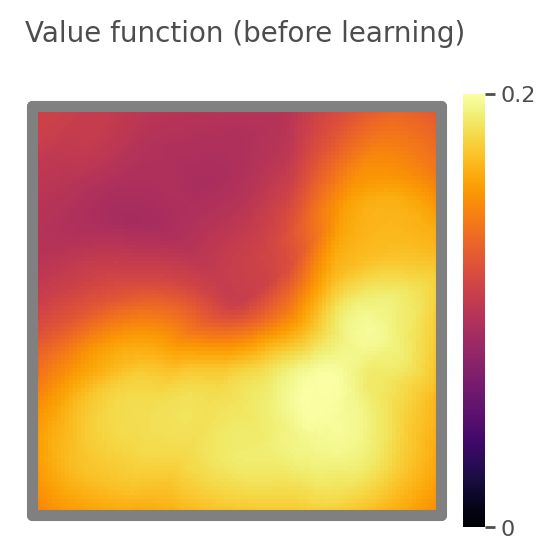

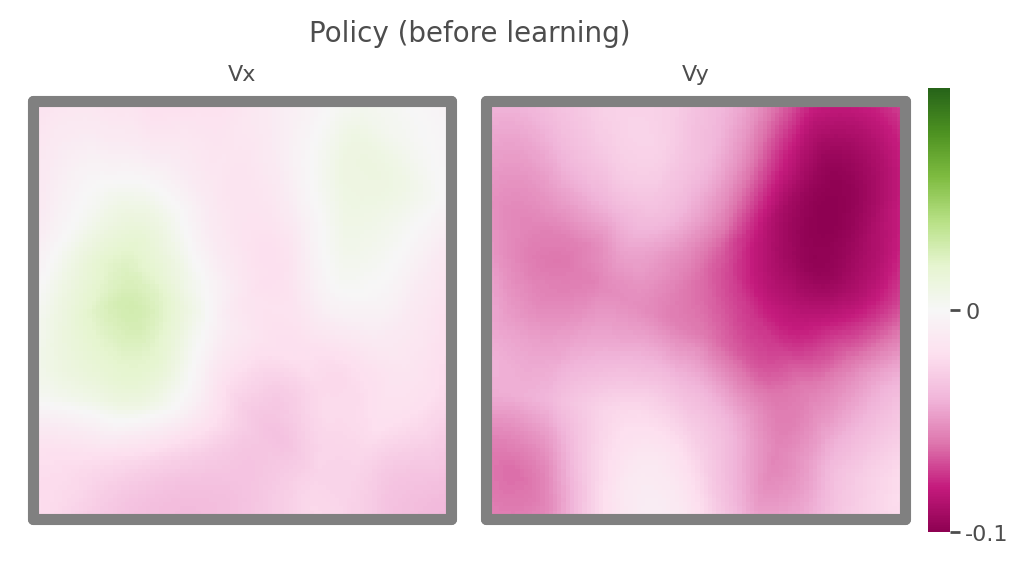

In [9]:
# Make the environment, egent and place cells 
env, ag = generate_navigation_task_env()
placecells = PlaceCells(ag, params={'n':50,}) 

#Make the actor and the critic (first make their core NNs then pass these to the full Actor and Critic classes)
actorNN  = VxVyGaussianMLP(n_in=placecells.n)
criticNN = MultiLayerPerceptron(n_in=placecells.n)
#
actor  = Actor(ag, params = {'input_layers':[placecells], 'NeuralNetworkModule':actorNN}); actor.colormap="PiYG"
critic = Critic(ag, params = {'input_layers':[placecells], 'NeuralNetworkModule':criticNN})

#This visualises the value function and "policy" over the entire environment
fig, ax = critic.plot_rate_map(); fig.suptitle("Value function (before learning)")
fig, ax = actor.plot_rate_map(zero_center=True); fig.suptitle("Policy (before learning)"); ax[0].set_title("Vx"); ax[1].set_title("Vy")

Now lets train the system. Note in practice its quite variable how long this takes. Some times it converges in under 500 episode, sometimes it takes 2000 or 3000! Good luck!

<success fraction>: 1.00, <episode time> 5.1:  23%|██▎       | 1132/5000 [02:37<08:57,  7.20it/s]


Figure saved to /Users/tomgeorge/Documents/RatInABox/demos/figures/28_08_23/NeuralNetworkNeurons_ratemaps_1531.png  & .svg
Figure saved to /Users/tomgeorge/Documents/RatInABox/demos/figures/28_08_23/NeuralNetworkNeurons_ratemaps_1531_1.png  & .svg
Figure saved to /Users/tomgeorge/Documents/RatInABox/demos/figures/28_08_23/trajectory_1531.png  & .svg


(<Figure size 600x600 with 1 Axes>, <AxesSubplot:>)

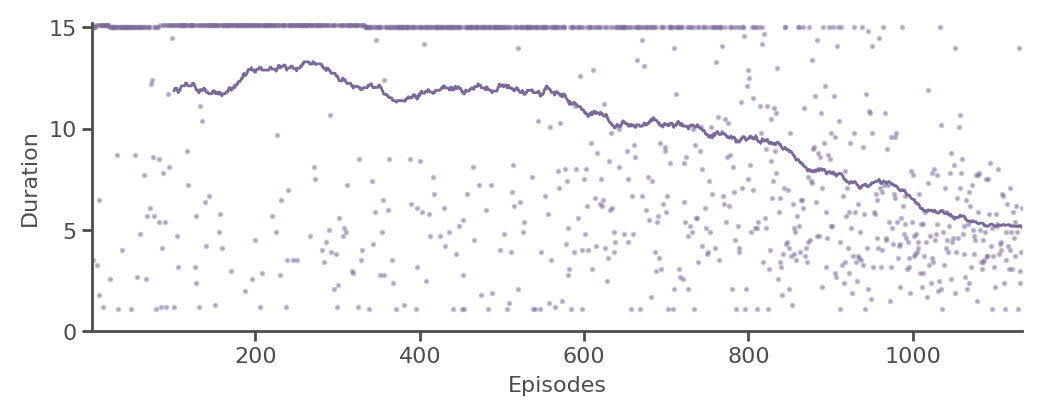

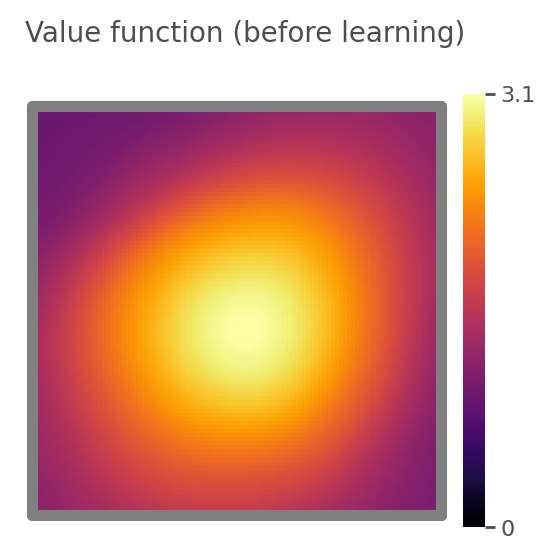

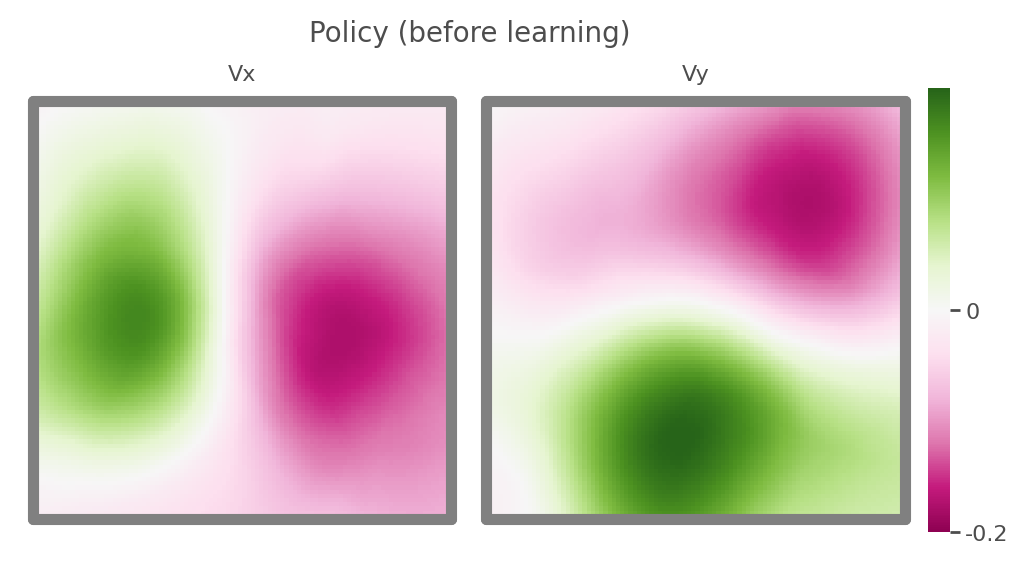

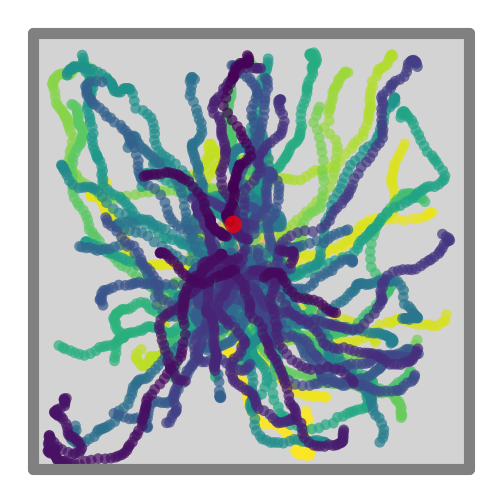

In [10]:
try: 
    for i in (pbar := tqdm(range(N_EPISODES), desc = "")):
        run_episode(env, 
                    ag,
                    actor, 
                    critic,
                    state_cells=[placecells],)
        success_frac = np.mean(np.array(env.episodes['meta_info'][-100:]) == "completed")
        episode_time = np.mean(env.episodes['duration'][-100:])
        pbar.set_description(f"<success fraction>: {success_frac:.2f}, <episode time> {episode_time:.1f}")
        if success_frac > 0.99 and i > 10: break
except KeyboardInterrupt:
    print("Interrupted by user")

#This plots the reqard history over training
fig, ax = plot_reward_history(env)
#This visualises the value function and "policy" over the entire environment
fig, ax = critic.plot_rate_map(); fig.suptitle("Value function (before learning)")
fig, ax = actor.plot_rate_map(zero_center=True); fig.suptitle("Policy (before learning)"); ax[0].set_title("Vx"); ax[1].set_title("Vy")
#Shows the trajectory of the agent over the last 100 episodes
fig, ax = ag.plot_trajectory(color="changing",t_start=env.episodes['start'][-100],t_end=env.episodes['start'][-1],); display_reward_patch(fig,ax)

In [20]:
# ag.animate_trajectory(color="changing",t_start=env.episodes['start'][-30],t_end=env.episodes['start'][-1],speed_up=10, additional_plot_func=display_reward_patch)

## Egocentric 

What if, instead, the actor received egocentric representation of the environment (as opposed to the allocentric representation provided by place cells)? We can model this with RatInABox `FieldOfViewOVCs`. These are object vector cells -- each tuned to respond to an object, here the reward port, at a specific angle and distance from the agent  -- arranged in order to mimic the field of view of the agent.

Lets see how this representation would look like under a random policy: 

In [11]:
from ratinabox.Neurons import FieldOfViewOVCs

env, ag = generate_navigation_task_env()
ag.head_direction_smoothing_timescale = 0.3 #how much to "smooth" the head direction (helps stability)
env.add_object(object=GOAL_POS, type=0) #this object represents the reward

#Make the FoV cells. They are selective to the same type of object as the one we added to model the reward, so the agent can "see" the reward
fov_ovcs = FieldOfViewOVCs(ag, params={'object_tuning_type':0, 'distance_range': [0.1, 0.3], 'angle_range': [0, 90], 'spatial_resolution': 0.06})

while ag.t < 30: 
    ag.update()
    fov_ovcs.update()

In [12]:
ag.animate_trajectory(color="changing",t_start=0,t_end=ag.t,speed_up=10, additional_plot_func=fov_ovcs.display_vector_cells)

Animation saved to /Users/tomgeorge/Documents/RatInABox/demos/figures/28_08_23/trajectory_1531.mp4


Now lets try train our RL agent with this representation. We'll use the same actor and critic as before, but now the actor will receive the firing rate of the `FieldOfViewOVCs` as input. The critic will continue to recieve allocentric input from place cells (feel free to try play around with this!). 

Since the actor now recieves egocentric information it it sensible to assume it outputs egocentric actions (i.e. the drift velocity is in the same coordinate frame as the agents current heading direction). Since the RatInABox package requires allocentric velocities we'll do this conversion _after_ selecting the action. 

Figure saved to /Users/tomgeorge/Documents/RatInABox/demos/figures/28_08_23/NeuralNetworkNeurons_ratemaps_1532_4.png  & .svg
Figure saved to /Users/tomgeorge/Documents/RatInABox/demos/figures/28_08_23/NeuralNetworkNeurons_ratemaps_1532_5.png  & .svg


Text(0.5, 0.98, '(for an agent looking North ↑)')

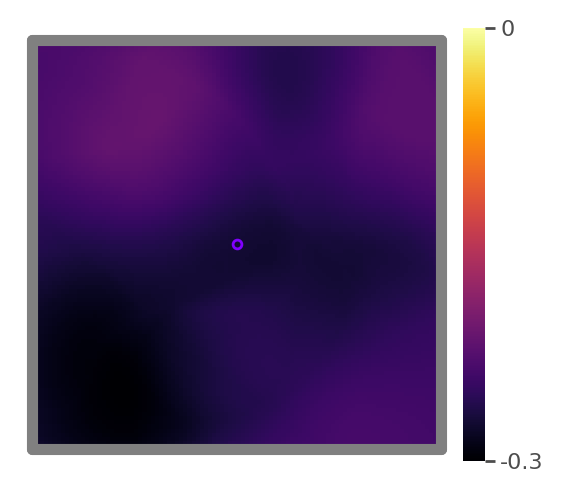

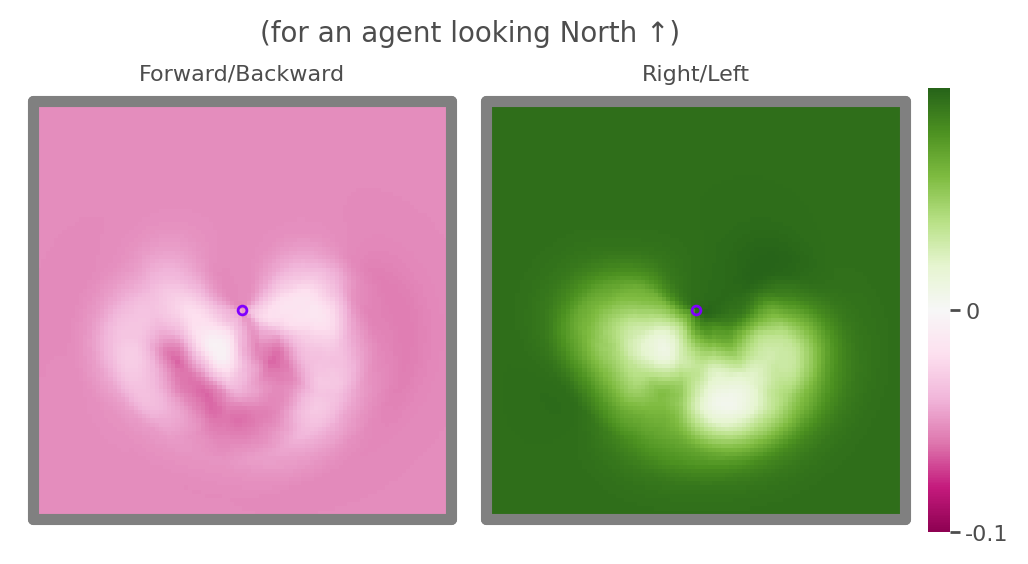

In [17]:
# Make the environment, egent and place cells 
env, ag = generate_navigation_task_env()
env.add_object(object=GOAL_POS, type=0)
ag.head_direction_smoothing_timescale = 0.5
placecells = PlaceCells(ag, params={'n':50,})
fov_ovcs = FieldOfViewOVCs(ag, params={'object_tuning_type':0, 'distance_range': [0.1, 0.3], 'angle_range': [0, 90], 'spatial_resolution': 0.06})

#Make the actor and the critic (first make their core NNs then pass these to the full Actor and Critic classes)
actorNN  = VxVyGaussianMLP(n_in=fov_ovcs.n)
criticNN = MultiLayerPerceptron(n_in=placecells.n)
optim = lambda params: torch.optim.SGD(params, lr=ETA,  maximize=True, weight_decay=L2)

actor  = Actor(ag, params = {'input_layers':[fov_ovcs], 'NeuralNetworkModule':actorNN, 'optimizer':optim}); actor.colormap="PiYG"
critic = Critic(ag, params = {'input_layers':[placecells], 'NeuralNetworkModule':criticNN,'optimizer':optim})

critic.plot_rate_map()
fig, ax = actor.plot_rate_map(head_direction = [0,1], zero_center=True); ax[0].set_title("Forward/Backward"); ax[1].set_title("Right/Left"); fig.suptitle("(for an agent looking North ↑)")

The only difference from part 1 is that now the actor outputs an egocentric action which we must remember ot convert to allocentric, to do this we wrote a function above which we trigger by adding the kwarg `egocentric_actions=True`.

Tip: In practise this learning is much "smoother" than the allocentric case but if you haven't seen signals its starting to learn within a few hundred episode try reinitialise and start again.

<success fraction>: 0.99, <episode time> 6.0:  27%|██▋       | 1373/5000 [03:10<08:21,  7.23it/s]


Figure saved to /Users/tomgeorge/Documents/RatInABox/demos/figures/28_08_23/NeuralNetworkNeurons_ratemaps_1535.png  & .svg
Figure saved to /Users/tomgeorge/Documents/RatInABox/demos/figures/28_08_23/trajectory_1535.png  & .svg


(<Figure size 600x600 with 1 Axes>, <AxesSubplot:>)

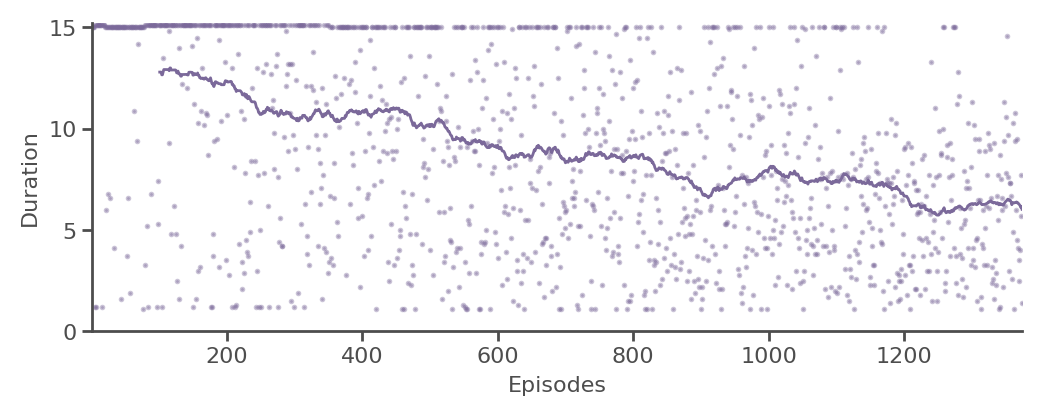

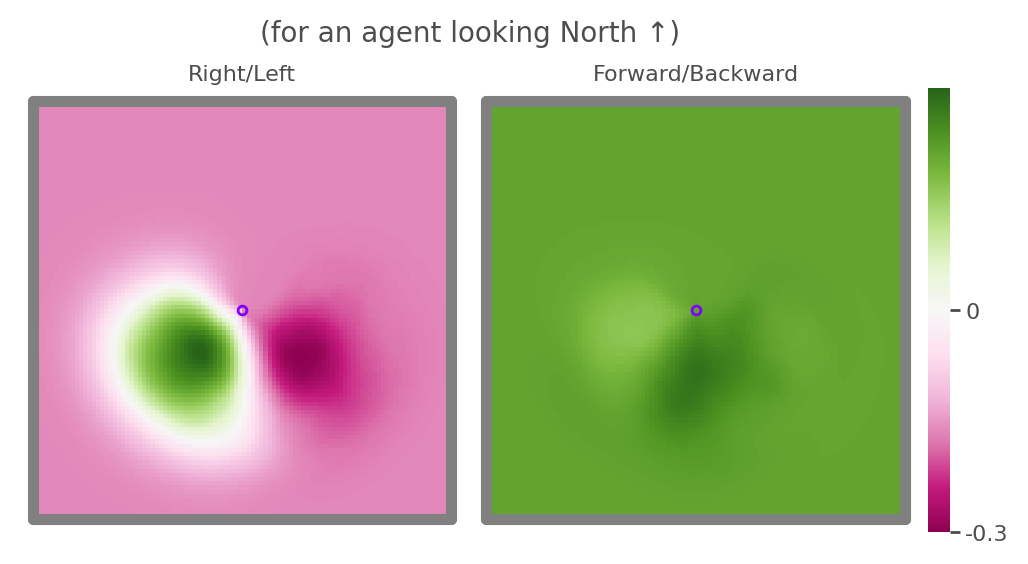

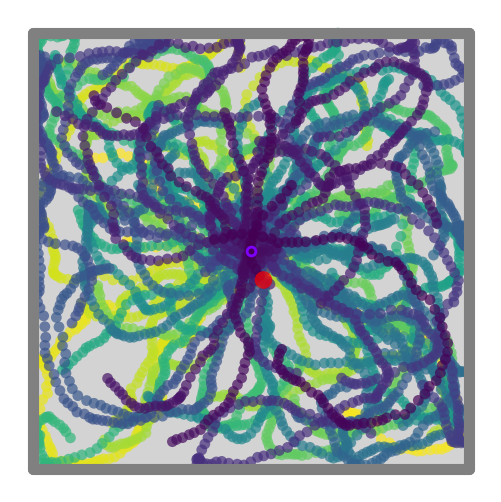

In [18]:
try: 
    for i in (pbar := tqdm(range(N_EPISODES), desc = "")):
        run_episode(env, 
                    ag,
                    actor, 
                    critic,
                    state_cells=[placecells, fov_ovcs],
                    egocentric_actions=True,)
        success_frac = np.mean(np.array(env.episodes['meta_info'][-100:]) == "completed")
        episode_time = np.mean(env.episodes['duration'][-100:])
        pbar.set_description(f"<success fraction>: {success_frac:.2f}, <episode time> {episode_time:.1f}")
        if success_frac > 0.98 and i > 10: break
except KeyboardInterrupt:
    print("Interrupted by user")

fig, ax = plot_reward_history(env)
# ratinabox.utils.save_figure(fig, "reward_history")
fig, ax = actor.plot_rate_map(head_direction = [0,1], zero_center=True); ax[0].set_title("Right/Left"); ax[1].set_title("Forward/Backward"); fig.suptitle("(for an agent looking North ↑)")
# ratinabox.utils.save_figure(fig,"policy")
fig, ax = ag.plot_trajectory(color="changing",t_start=env.episodes['start'][-100],t_end=env.episodes['start'][-1],); display_reward_patch(fig,ax)

In [19]:
# ag.animate_trajectory(color="changing",t_start=env.episodes['start'][-10],t_end=env.episodes['start'][-1],speed_up=5, additional_plot_func=fov_ovcs.display_vector_cells)